# <font color=red><center>**My Content : Books recommandation app**</center></font>

# <font color=salmon>PART 1 - REMINDER OF THE PROJECT CONTEXT</font>

## **<font color=green>The project</font>**
"My Content" is a start-up who's goal is to encourage people to read by recommending relevant content to users.

In this project, we want to create a first MVP that will take the form of an application that will be recommend relevant articles to users based on their implicit preferences, their profiles and the articles content. This is known as a Recommender System. Thus, we will complete the following tasks: 

* We will compare different models of recommender system on the Globo.com dataset. 

* We will use Azure Functions to store the recommendations in Azure CosmosDB and to make the recommendations available to the users.

* We will integrate that Azure Functions into a Streamlit App that will be able to recommend relevant articles to users. 

## **<font color=green>Dataset</font>**
We will work with the Globo.com 

The dataset is composed of the following files :

- clicks/clicks/ : contains 385 CSV files
- clicks_hour_*.csv : contains one hour of clicks on the website
- articles_embeddings.pickle : pickle file containing the embeddings of the articles
- articles_metadata.csv : CSV file containing the metadata of the articles

# <font color=salmon>PART 2 - LIBRARIES, PARAMETERS, HELPERS</font>

## **<font color=green>Loading libraries</font>**

In [4]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries

from datetime import datetime
from pathlib import Path

import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import plotly.io as pio

pio.renderers.default = "jupyterlab"

pd.options.plotting.backend = "plotly"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

CLICK_THRESHOLD = 0
SCORE_SAMPLE = 100
DISPLAY_MODE = 1

# <font color=salmon>PART 3 - EXPLORATORY DATA ANALYSIS (EDA)</font>

## **<font color=blue>Articles Metadata</font>**

### **<font color=green>Data loading</font>**

In [5]:
# Load and describe Articles Metada data
RAW_DATA_PATH = "../data"

PATH_ARTICLES_DATA = "./data/articles_metadata.csv"
articles_metadata = pd.read_csv(Path(RAW_DATA_PATH, "articles_metadata.csv"),
        parse_dates=["created_at_ts"],
        date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
        dtype={
            "article_id": "category",
            "category_id": "category",
            "publisher_id": "category",
            "words_count": "int",
        },
    )

articles_metadata = articles_metadata.astype({"created_at_ts": "datetime64[ns]"})

articles_metadata.describe(include="all", datetime_is_numeric=True)

article_id category_id                  created_at_ts publisher_id  \
count   364047     364047      364047                         364047        
unique  364047     461         NaN                            1             
top     0          281         NaN                            0             
freq    1          12817       NaN                            364047        
mean    NaN        NaN         2016-09-17 01:25:54.949498624  NaN           
min     NaN        NaN         2006-09-27 13:14:35            NaN           
25%     NaN        NaN         2015-10-15 18:00:43.500000     NaN           
50%     NaN        NaN         2017-03-13 17:27:29            NaN           
75%     NaN        NaN         2017-11-05 15:09:11            NaN           
max     NaN        NaN         2018-03-13 13:12:30            NaN           
std     NaN        NaN         NaN                            NaN           

          words_count  
count   364047.000000  
unique NaN             
top    NaN             
freq   NaN             
mean    190.897727     
min     0.000000       
25%     159.000000     
50%     186.000000     
75%     218.000000     
max     6690.000000    
std     59.502766

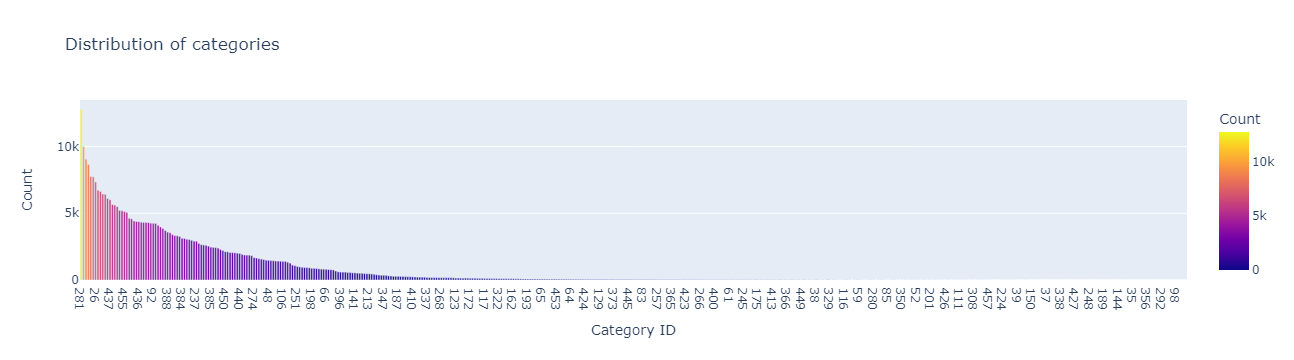

In [6]:
## Visualize Articles Categories distribution

articles_metadata["category_id"].value_counts().plot(
    kind="bar",
    labels={
        "index": "Category ID",
        "value": "Count",
    },
    color="value",
    title="Distribution of categories",
)


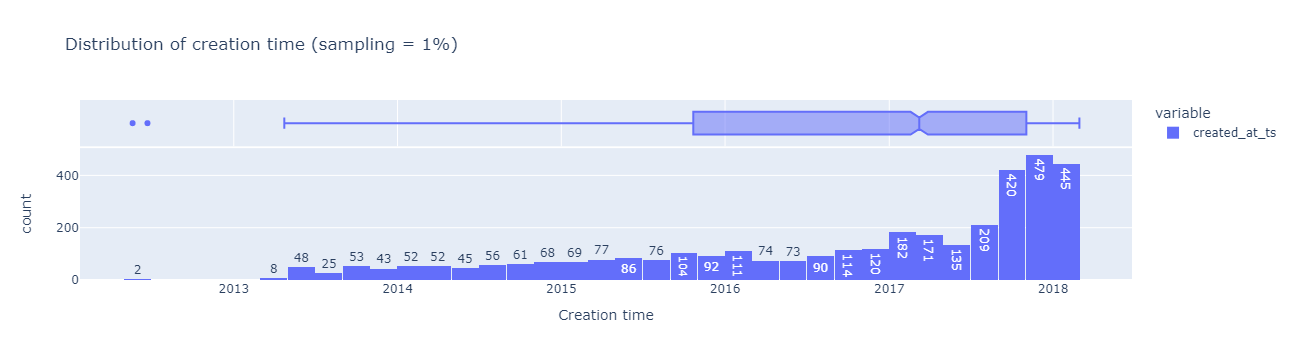

In [8]:
## Visualize Articles Creation time distribution

articles_metadata.sample(frac=0.01)["created_at_ts"].plot(
    kind="histogram",
    title="Distribution of creation time (sampling = 1%)",
    labels={
        "value": "Creation time",
    },
    text_auto=True,
    marginal="box",
)

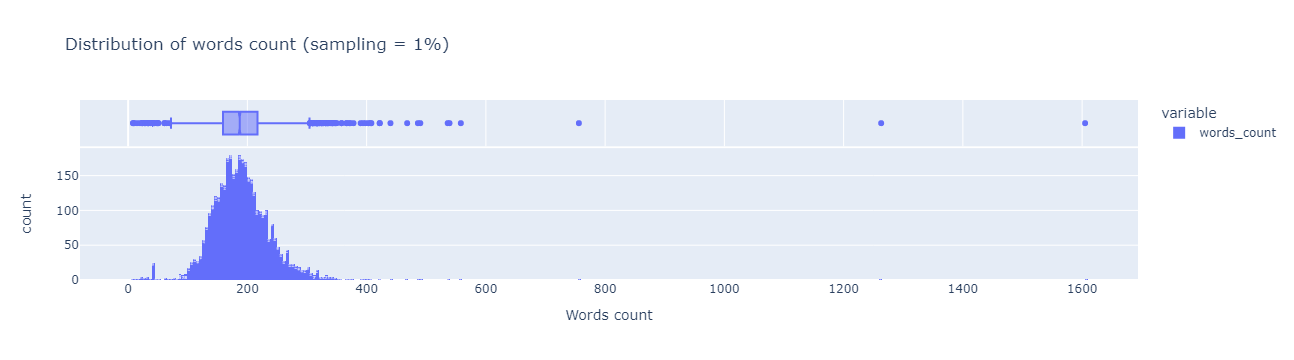

In [9]:
## Visualize Articles Word count distribution

articles_metadata["words_count"].sample(frac=0.01).plot(
    kind="histogram",
    title="Distribution of words count (sampling = 1%)",
    labels={
        "value": "Words count",
    },
    text_auto=True,
    marginal="box",
)

## **<font color=blue>Articles Clicks</font>**

### **<font color=green>Data loading</font>**

In [10]:
## Load and describe Clicks data
RAW_DATA_PATH = "../data"
click_file_path ="../data/clicks"

PATH_ARTICLES_DATA = "../Projet_9/data/articles_metadata.csv"

clicks = pd.concat(
    [
        pd.read_csv(
            Path(click_file_path),
            parse_dates=["session_start", "click_timestamp"],
            date_parser=lambda x: datetime.fromtimestamp(int(int(x) / 1000)),
            dtype={
                "user_id": "category",
                "session_id": "category",
                "session_size": "int",
                "click_article_id": "category",
                "click_environment": "category",
                "click_deviceGroup": "category",
                "click_os": "category",
                "click_country": "category",
                "click_region": "category",
                "click_referrer_type": "category",
            },
        )
        for click_file_path in tqdm(
            sorted(Path(RAW_DATA_PATH, "clicks/clicks").glob("clicks_hour_*.csv"))
        )
    ],
    sort=False,
    ignore_index=True,
    verify_integrity=True,
)

clicks = clicks.astype(
    {"session_start": "datetime64[ns]", "click_timestamp": "datetime64[ns]"}
)

clicks.describe(include="all", datetime_is_numeric=True)

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:31<00:00, 12.15it/s]


user_id        session_id                  session_start  \
count   2988181  2988181           2988181                         
unique  322897   1048594           NaN                             
top     5890     1507563657895091  NaN                             
freq    1232     124               NaN                             
mean    NaN      NaN               2017-10-08 16:17:08.013155328   
min     NaN      NaN               2017-10-01 04:37:03             
25%     NaN      NaN               2017-10-04 15:35:52             
50%     NaN      NaN               2017-10-08 22:09:00             
75%     NaN      NaN               2017-10-11 21:16:54             
max     NaN      NaN               2017-10-17 05:36:19             
std     NaN      NaN               NaN                             

        session_size click_article_id                click_timestamp  \
count   2.988181e+06  2988181          2988181                         
unique NaN            46033            NaN                             
top    NaN            160974           NaN                             
freq   NaN            37213            NaN                             
mean    3.901885e+00  NaN              2017-10-08 16:51:05.070374400   
min     2.000000e+00  NaN              2017-10-01 05:00:00             
25%     2.000000e+00  NaN              2017-10-04 16:20:52             
50%     3.000000e+00  NaN              2017-10-08 22:35:30             
75%     4.000000e+00  NaN              2017-10-11 21:43:24             
max     1.240000e+02  NaN              2017-11-13 21:04:14             
std     3.929941e+00  NaN              NaN                             

       click_environment click_deviceGroup click_os click_country  \
count   2988181           2988181           2988181  2988181        
unique  3                 5                 8        11             
top     4                 1                 17       1              
freq    2904478           1823162           1738138  2852406        
mean    NaN               NaN               NaN      NaN            
min     NaN               NaN               NaN      NaN            
25%     NaN               NaN               NaN      NaN            
50%     NaN               NaN               NaN      NaN            
75%     NaN               NaN               NaN      NaN            
max     NaN               NaN               NaN      NaN            
std     NaN               NaN               NaN      NaN            

       click_region click_referrer_type  
count   2988181      2988181             
unique  28           7                   
top     25           2                   
freq    804985       1602601             
mean    NaN          NaN                 
min     NaN          NaN                 
25%     NaN          NaN                 
50%     NaN          NaN                 
75%     NaN          NaN                 
max     NaN          NaN                 
std     NaN          NaN

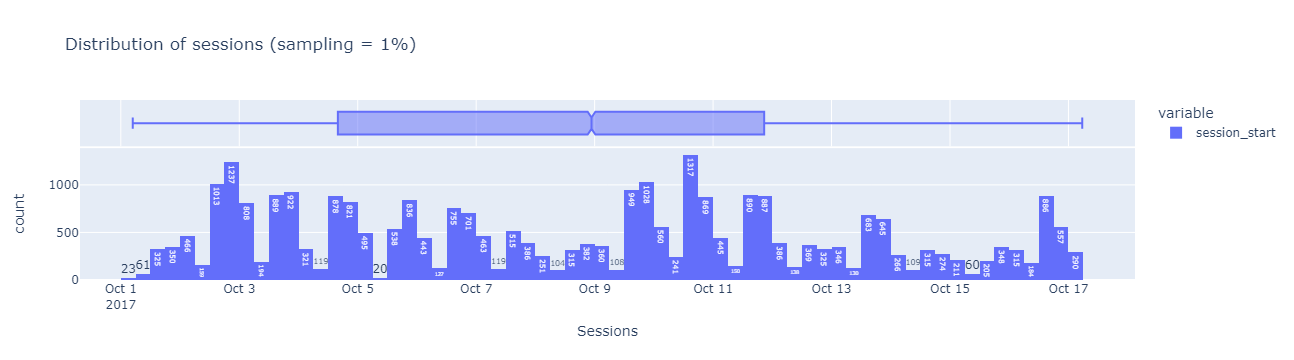

In [12]:
## Visualize Click sessions distribution over time

clicks.sample(frac=0.01)["session_start"].plot(
    kind="histogram",
    title="Distribution of sessions (sampling = 1%)",
    labels={
        "value": "Sessions",
    },
    text_auto=True,
    marginal="box",
)

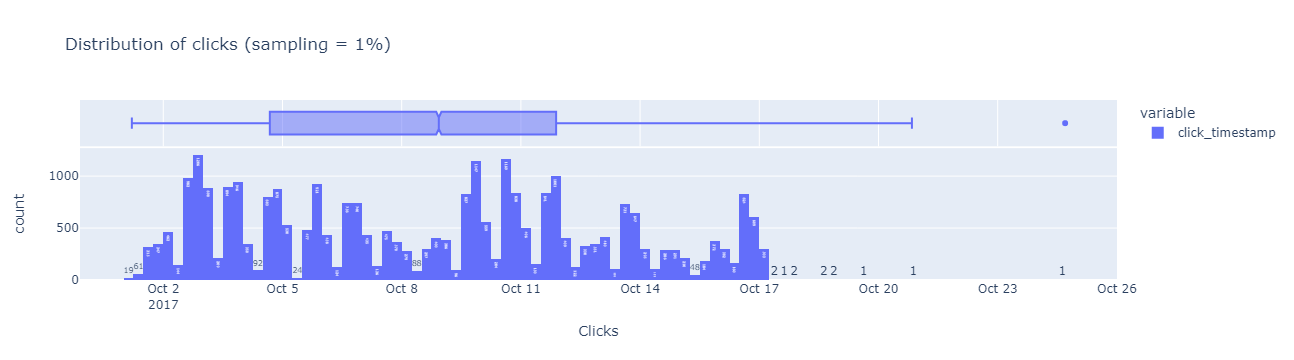

In [13]:
# Visualize Clicks distribution over time

clicks.sample(frac=0.01)["click_timestamp"].plot(
    kind="histogram",
    title="Distribution of clicks (sampling = 1%)",
    labels={
        "value": "Clicks",
    },
    text_auto=True,
    marginal="box",
)

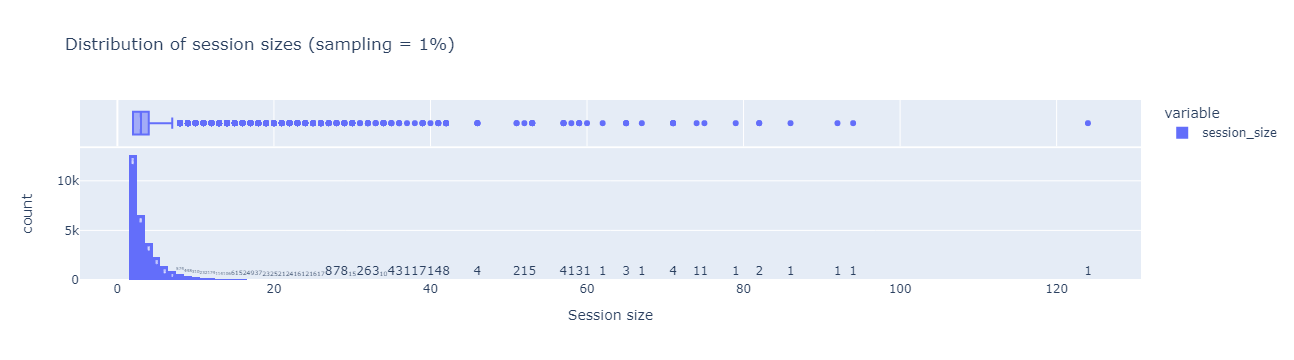

In [14]:
# Visualize Clicks Sessions size

clicks.sample(frac=0.01)["session_size"].plot(
    kind="histogram",
    title="Distribution of session sizes (sampling = 1%)",
    labels={
        "value": "Session size",
    },
    text_auto=True,
    marginal="box",
)

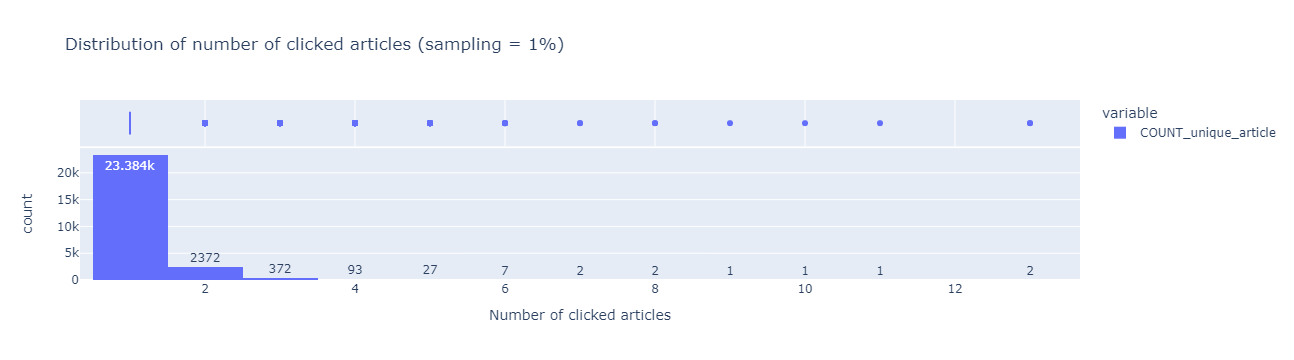

In [15]:
# Visualize number of clicked articles per user (user engagement)

clicks.sample(frac=0.01).groupby("user_id").agg(
    COUNT_unique_article=("click_article_id", lambda x: len(set(list(x)))),
).plot(
    kind="histogram",
    title="Distribution of number of clicked articles (sampling = 1%)",
    labels={
        "value": "Number of clicked articles",
    },
    text_auto=True,
    marginal="box",
)

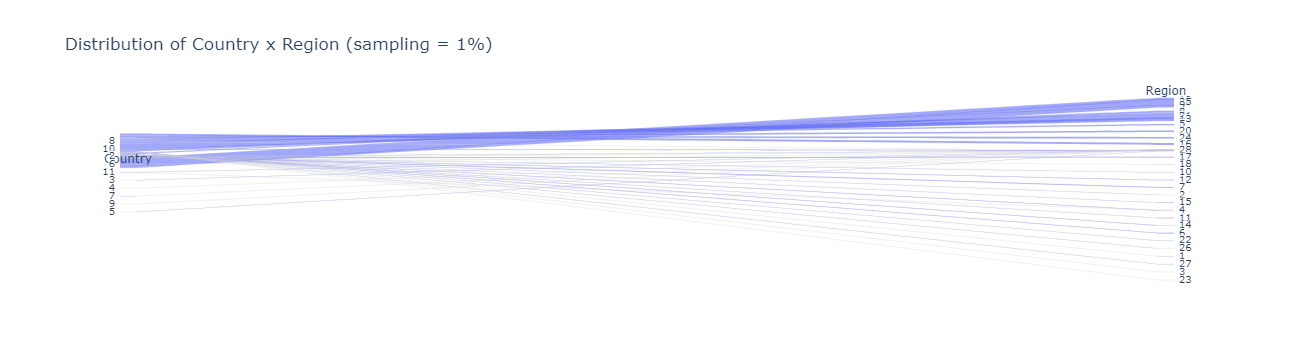

In [16]:
# Visualize click context : user geolocation

fig = px.parallel_categories(
    clicks.sample(frac=0.01),
    dimensions=["click_country", "click_region"],
    title="Distribution of Country x Region (sampling = 1%)",
    labels={
        "click_country": "Country",
        "click_region": "Region",
    },
)
fig.show()

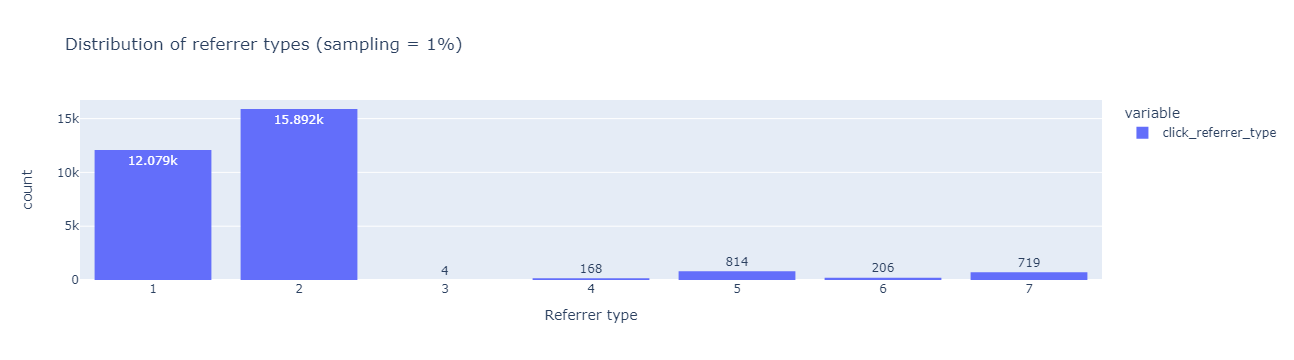

In [17]:
# Visualize click context : user referrer

clicks.sample(frac=0.01)["click_referrer_type"].plot(
    kind="histogram",
    title="Distribution of referrer types (sampling = 1%)",
    labels={
        "value": "Referrer type",
    },
    category_orders={
        "value": [str(i) for i in range(1, 8)],
    },
    text_auto=True,
)

### **<font color=blue>Articles embeddings</font>** 

### **<font color=green>Data loading</font>** 

In [18]:
# Load and describe Articles Embeddings data

articles_embeddings = pd.read_pickle(Path(RAW_DATA_PATH, "articles_embeddings.pickle"))

articles = pd.DataFrame(
    articles_embeddings,
    columns=["embedding_" + str(i) for i in range(articles_embeddings.shape[1])],
)
articles["words_count"] = articles_metadata["words_count"]
articles["category_id"] = articles_metadata["category_id"]
articles["article_id"] = articles_metadata["article_id"]

articles.describe(include="all", datetime_is_numeric=True)

# Sampling (1%)
articles_sample = articles.sample(frac=0.01)

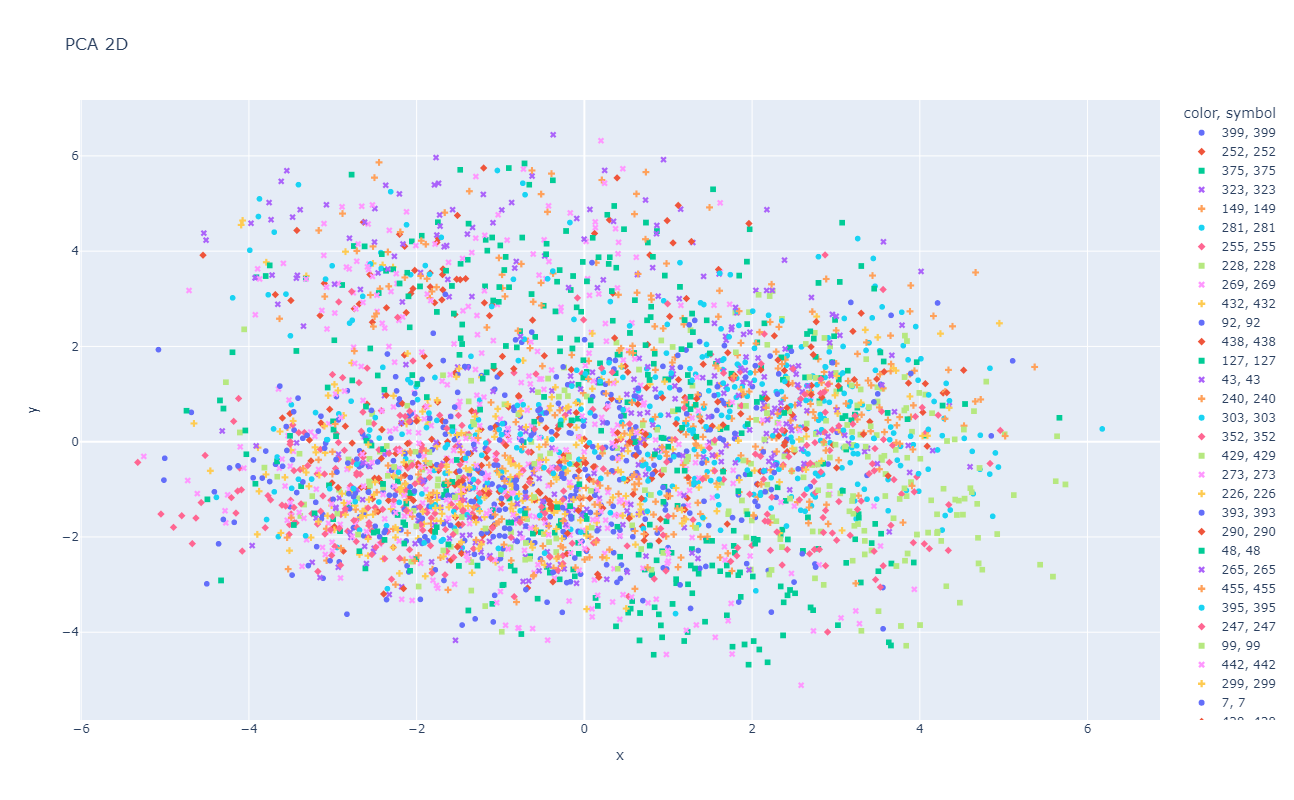

In [19]:
# Visualize Articles Embeddings in 2D PCA

pca = PCA(n_components=2)
articles_pca = pca.fit_transform(
    articles_sample[
        ["embedding_" + str(i) for i in range(articles_embeddings.shape[1])]
    ]
)

# Plot the data in the PCA space
fig = px.scatter(
    x=articles_pca[:, 0],
    y=articles_pca[:, 1],
    color=articles_sample["category_id"],
    symbol=articles_sample["category_id"],
    title="PCA 2D",
    width=1200,
    height=800,
)
fig.show()

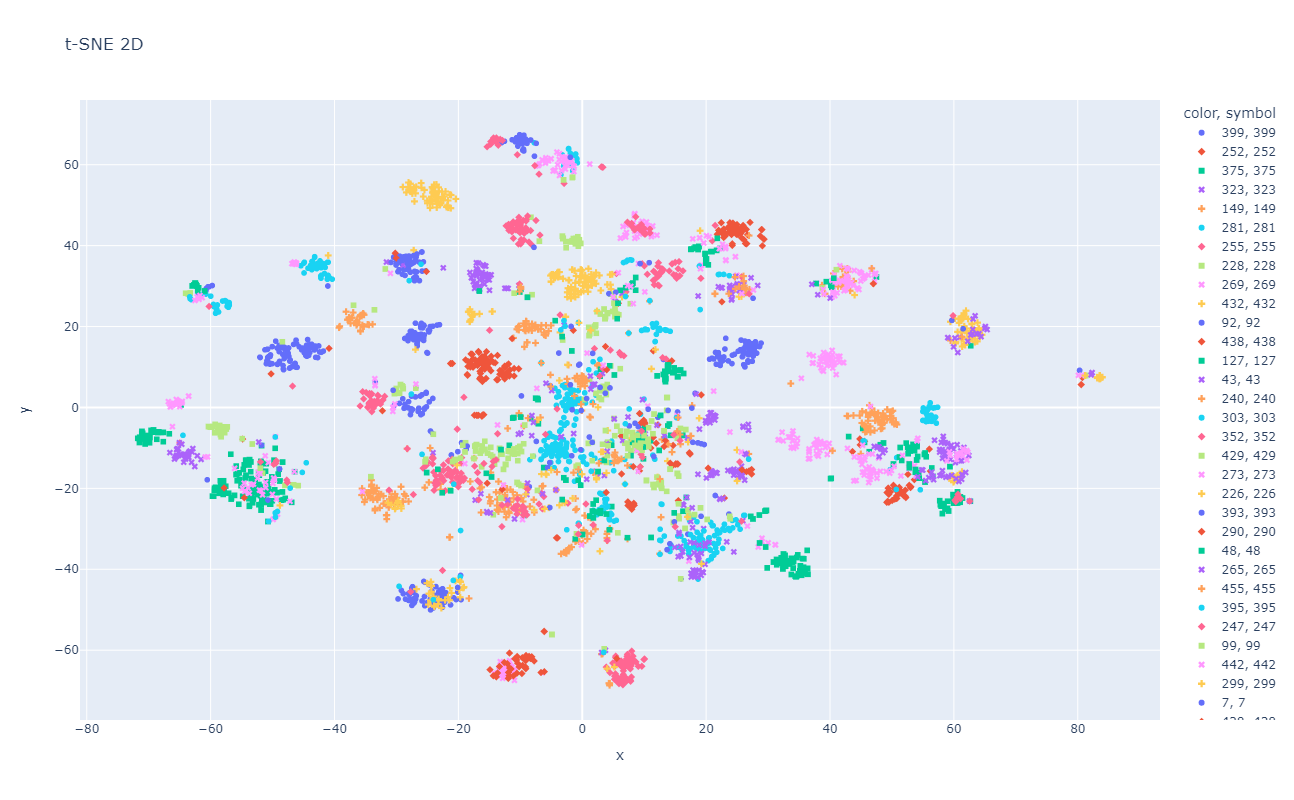

In [20]:
# Visualize Articles Embeddings in 2D t-SNE

tsne = TSNE(n_components=2)
articles_tsne = tsne.fit_transform(
    articles_sample[
        ["embedding_" + str(i) for i in range(articles_embeddings.shape[1])]
    ]
)

# Plot the data in the PCA space
fig = px.scatter(
    x=articles_tsne[:, 0],
    y=articles_tsne[:, 1],
    color=articles_sample["category_id"],
    symbol=articles_sample["category_id"],
    title="t-SNE 2D",
    width=1200,
    height=800,
)
fig.show()